
# The Efficient Frontier: Markowitz portfolio optimization

https://blog.quantopian.com/markowitz-portfolio-optimization-2

### Simulations

We 1st use simulated data to illustrate the concepts, then move on to stock data.

Assume that we have 4 assets, each with a return series of length 1000.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [3]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

In [4]:
return_vec.shape

(4, 1000)

Text(0,0.5,'returns')

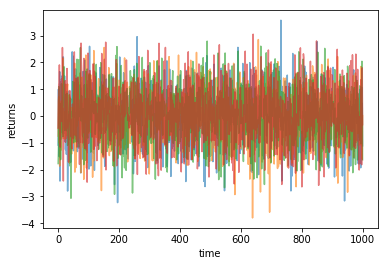

In [5]:
plt.plot(return_vec.T, alpha=.6);
plt.xlabel('time')
plt.ylabel('returns')

These return series can be used to create a wide range of portfolios, which all
have different returns and risks (standard deviation). We can produce a wide range
of random weight vectors and plot those portfolios. 

As we want all our capital to be invested, this vector will have to sum to one.

In [6]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print (rand_weights(n_assets))
print (rand_weights(n_assets))

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


Next, lets evaluate how many of these random portfolios would perform. 

Towards this goal we are calculating the mean returns as well as the volatility (here we are using standard deviation). 

You can also see that there is a filter that only allows to plot portfolios with a standard deviation of < 2 for better illustration.

In [7]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

https://zerodha.com/varsity/chapter/risk-part-2-variance-covariance/

In the code you will notice the calculation of the return with:

$E = p^{T}w$


where E is the expected return, p.T is the transpose of the vector for the mean
returns for each time series and w is the weight vector of the portfolio.  

Next, we calculate the standard deviation with

$sigma = \sqrt{w^{T}Cw}$

where  is the covariance matrix of the returns which is a NxN matrix. 

Please note that if we simply calculated the simple standard deviation with the appropriate weighting using  std(array(ret_vec).T*w) we would get a slightly different ’bullet’. 

This is because the simple standard deviation calculation would not take covariances into account. 

In the covariance matrix, the values of the diagonal represent the simple variances of each asset while the off-diagonals are the variances between the assets. 

By using ordinary std() we effectively only regard the diagonal and miss the rest. A small but significant difference.

Lets generate the mean returns and volatility for 500 random portfolios:

In [10]:
n_portfolios = 500
means, stds = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])

Upon plotting those you will observe that they form a characteristic parabolic
shape called the ‘Markowitz bullet‘ with the boundaries being called the ‘efficient
frontier‘, where we have the lowest variance for a given expected.

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

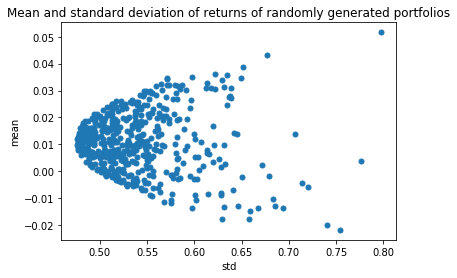

In [11]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

### Markowitz optimization and the Efficient Frontier¶
Once we have a good representation of our portfolios as the blue dots show we can calculate the efficient frontier Markowitz-style.

This is done by minimising 

${w^{T}Cw}$

for w on the expected portfolio return  whilst keeping the sum of all the
weights equal to 1:

$\sum _{i}w_{i} = 1$

The $\mathit{mus}$ vector produces a series of expected return values  in a non-linear and more appropriate way. 

We will see later that we don‘t need to calculate a lot of these as they perfectly fit a parabola, which can safely be extrapolated for higher values.

